In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [36]:
# Neural Network Model
class PoissonNet(tf.keras.Model):
    def __init__(self):
        super(PoissonNet, self).__init__()
        self.dense1 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

In [37]:
# Trial solution u(x, y)
def trial_solution(xy, net):
    x, y = xy[:, 0:1], xy[:, 1:2]
    return tf.sin(np.pi * x) * (1 - x) * tf.sin(np.pi * y) * (1 - y) * net(xy)
    #x * (1 - x) * y * (1 - y) * net(xy)

In [38]:
# Compute Laplacian ∇²u
def compute_laplacian(xy, net):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(xy)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(xy)
            u = trial_solution(xy, net)

        # Compute first-order derivatives as Jacobian
        grad_u = tape1.gradient(u, xy)  # Gradient (du/dx, du/dy)

    if grad_u is None:
        raise ValueError("Gradient of u with respect to xy is None. Ensure xy is watched.")

    # Compute second-order derivatives
    laplacian_u = tf.reduce_sum(tape2.gradient(grad_u, xy), axis=1, keepdims=True)  # Sum of second derivatives

    return laplacian_u

In [39]:
# Define the loss function
def loss_function(xy, net):
    laplacian_u = compute_laplacian(xy, net)
    f_xy = -2*np.pi**2*tf.sin(np.pi * xy[:, 0:1]) * tf.sin(np.pi * xy[:, 1:2])  # Example f(x,y)
    return tf.reduce_mean(tf.square(laplacian_u - f_xy))

In [40]:
# Generate training points in [0,1]x[0,1]
N_points = 1000
xy_train = tf.convert_to_tensor(np.random.rand(N_points, 2), dtype=tf.float32)

# Initialize network and optimizer
net = PoissonNet()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [41]:
# Training loop
epochs = 5000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = loss_function(xy_train, net)
    gradients = tape.gradient(loss, net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, net.trainable_variables))

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.6f}")

Epoch 0, Loss: 89.404831
Epoch 500, Loss: 58.807838
Epoch 1000, Loss: 56.020241
Epoch 1500, Loss: 54.243103
Epoch 2000, Loss: 50.448406
Epoch 2500, Loss: 43.549343
Epoch 3000, Loss: 35.211617
Epoch 3500, Loss: 33.753017
Epoch 4000, Loss: 32.847572
Epoch 4500, Loss: 32.131935


In [42]:
def exact(xy):
  return tf.sin(np.pi * xy[:, 0:1]) * tf.sin(np.pi * xy[:, 1:2])

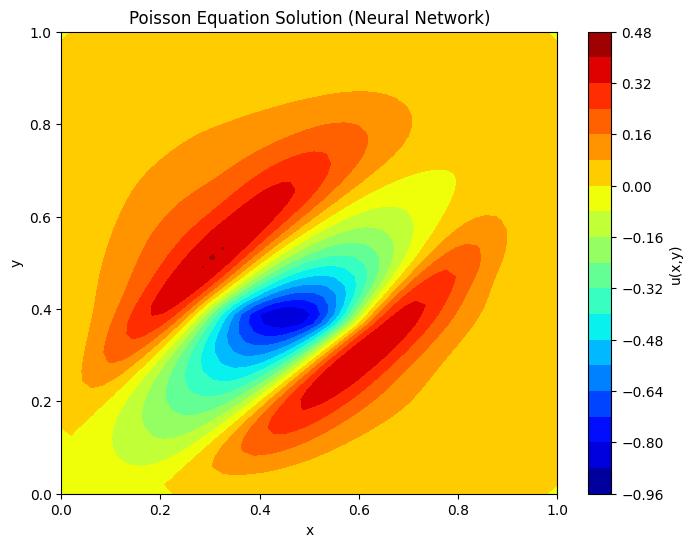

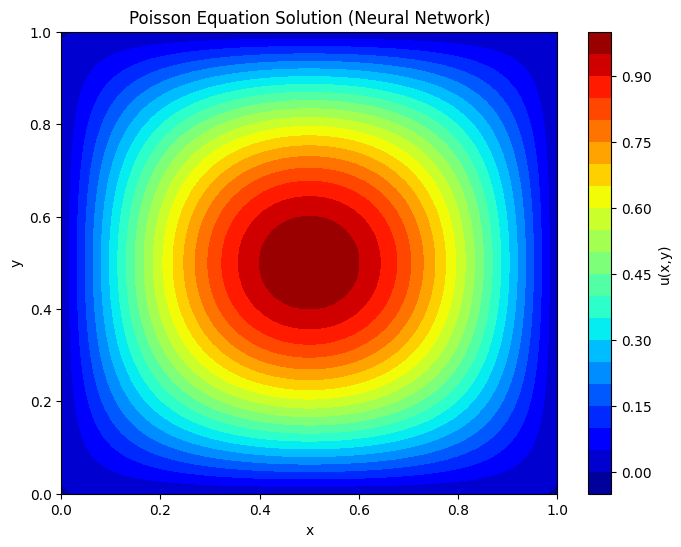

In [43]:
# Evaluate on a grid
N_grid = 50
x_vals = np.linspace(0, 1, N_grid)
y_vals = np.linspace(0, 1, N_grid)
X, Y = np.meshgrid(x_vals, y_vals)

xy_test = tf.convert_to_tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype=tf.float32)
u_pred = trial_solution(xy_test, net).numpy().reshape(N_grid, N_grid)
u_exact = exact(xy_test).numpy().reshape(N_grid, N_grid)
# Plot solution
plt.figure(figsize=(8,6))
plt.contourf(X, Y, u_pred, levels=20, cmap="jet")
plt.colorbar(label="u(x,y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Poisson Equation Solution (Neural Network)")
plt.show()

plt.figure(figsize=(8,6))
plt.contourf(X, Y, u_exact, levels=20, cmap="jet")
plt.colorbar(label="u(x,y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Poisson Equation Solution (Neural Network)")
plt.show()
